# 9-1. 프로젝트 : 모든 장르 간 편향성 측정해 보기
지금까지 우리는 영화 시놉시스 코퍼스를 가지고 영화 구분과 영화 장르 간에 내재된 편향성을 측정하는 작업을 진행해 보았습니다. 어느 정도는 우리의 상식과 일치하는 편향성이 측정되었을 것입니다.

이번에는 모든 장르에 대해 영화 구분과의 편향성 정도를 측정해 보겠습니다. 대부분의 과정은 이전 스텝에서 이미 진행한 내용을 참고해서 동일하게 진행 가능할 것입니다.

## 라이브러리 버전을 확인해 봅니다  
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


## 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

synopsis.txt(대략 17MB)에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보가 있습니다. (개봉된 영화 중 일부만 포함되어있습니다. 더 많은 영화 정보를 원하시면 KOBIS에서 확인하시기 바랍니다.) synopsis.txt의 일부를 읽어볼까요?
```python
cd ~/aiffel/weat && unzip synopsis.zip
```

In [4]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

이제 synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장해봅시다. konlpy 패키지를 이용해봅시다.

konlpy 패키지가 설치되지 않았다면 아래의 명령어로 설치하세요.
```python
pip install konlpy
```

In [5]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []    # corpus 저장
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [6]:
print(len(tokenized))

71156


In [7]:
tokenized

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤'],
 ['사랑', '두', '사람', '상우', '주체', '수', '정도', '그녀'],
 ['겨울', '만난', '두', '사람', '관계', '봄', '지나', '여름', '맞이', '삐걱', '거', '린다'],
 ['이혼', '경험', '은수', '상우', '결혼', '생각', '표정', '내비'],
 ['사랑', '상우', '은수', '단호', '말'],
 ['것', '사랑', '그', '사실', '상우', '어찌'],
 ['은수', '상우', '미련', '집착', '감정', '이기', '못', '서울', '강릉', '간다'],
 ['유사',
  '연령',
  '성별',
  '빈부',
  '차이',
  '정치',
  '입장',
  '불문',
  '국민',
  '통합',
  '온',
  '애국심',
  '성역',
  '일침',
  '다큐멘터리',
  '재작년',
  '전국',
  '민족',
  '민주',
  '유가족',
  '협의',
  '회의',
  '장기',
  '농성',
  '인상',
  '다큐멘터리',
  '민들레',
  '를',
  '독립영화',
  '집단',
  '눈사람',
  '이',
  '우리',
  '사회',
  '구석구석',
  '발',
  '애국심',
  '민족주의',
  '강요',
  '현장',
  '발굴',
  '카메라',
  '박홍',
  '서강대',
  '명예',
  '총장',
  '이도형',
  '한국',
  '논단',
  '발행',
  

## 2. 추출된 결과로 embedding model 만들기

In [11]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8801410794258118),
 ('다큐멘터리', 0.8489421010017395),
 ('드라마', 0.825715959072113),
 ('형식', 0.7919598817825317),
 ('영화로', 0.7904203534126282),
 ('코미디', 0.7860238552093506),
 ('감동', 0.7708384394645691),
 ('주제', 0.7688552141189575),
 ('스토리', 0.7637722492218018),
 ('소재', 0.7614311575889587)]

In [13]:
model.wv.most_similar(positive=['사랑'])

[('첫사랑', 0.7143352627754211),
 ('행복', 0.7083525657653809),
 ('진심', 0.6876035332679749),
 ('애정', 0.684423565864563),
 ('가슴', 0.68226557970047),
 ('고백', 0.6775510907173157),
 ('이별', 0.6732563972473145),
 ('운명', 0.6674416661262512),
 ('감정', 0.6662236452102661),
 ('우정', 0.6655359864234924)]

In [14]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.889226496219635),
 ('오페라', 0.8861454129219055),
 ('공연', 0.8799466490745544),
 ('영화감독', 0.8755799531936646),
 ('배우', 0.8706496953964233),
 ('데뷔', 0.8685646653175354),
 ('연기자', 0.867455005645752),
 ('각색', 0.8628537654876709),
 ('뮤지컬', 0.862402617931366),
 ('대본', 0.8598751425743103)]

- 키워드로 넣는 단어들과 비슷한 단어를 잘 출력하는 것을 볼 수 있습니다.

## 3. target, attribute 단어 셋 만들기
이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.

TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.
- target X, Y 와 attribute A, B에 대한 단어 셋 생성
- 영화 장르와 영화 구분(예술, 일반)정보를 사용 

In [15]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [16]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [17]:
print(type(art), type(gen))
print(len(art), len(gen))

<class 'str'> <class 'str'>
620208 3014815


WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요합니다. 이번 경우에는 예술영화, 일반영화라는 영화 구분별로 시놉시스를 모아 데이터를 구성했습니다. 그렇다면 예술영화를 잘 대표하는 단어란 예술영화 시놉시스에는 자주 나타나지만 그 외 다른 구분의 영화(예를 들어 일반영화) 시놉시스에는 자주 나타나지 않는 것을 고르는 것이 적당할 것입니다.

In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [19]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출

In [21]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [22]:
len(w1_), len(w2_)

(100, 100)

In [23]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [24]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [25]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [26]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [27]:
len(genre)

21

In [28]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [29]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

중복된 것이 종종 있지만 art, gen 두 개의 단어 셋을 추출했을 때에 비해 적습니다. 그러므로 중복을 체크해서 삭제하기보다 그대로 사용하겠습니다.

## 4. WEAT score 계산과 시각화
영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

In [30]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [31]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B  #, c_a, c_b

- WEAT score 계산 함수 생성

In [33]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B) # x의 편향
    s_Y = s(Y, A, B) # y의 편향 

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [34]:
# 구현결과를 담을 21x21 matrix
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [35]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [36]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i],genre_name[j],matrix[i][j])
            

SF 멜로로맨스 -1.3560553
공포(호러) 다큐멘터리 1.1855547
기타 멜로로맨스 -1.1668744
다큐멘터리 멜로로맨스 -1.4927298
다큐멘터리 미스터리 -1.3043875
다큐멘터리 성인물(에로) -1.2347023
다큐멘터리 스릴러 -1.1746137
멜로로맨스 범죄 1.2361692
멜로로맨스 서부극(웨스턴) 1.2257744
멜로로맨스 애니메이션 1.1750128
멜로로맨스 전쟁 1.4557253
미스터리 전쟁 1.1459999


### WEAT score 결과 해석
- 다큐멘터리는 모두 일반영화와 관련이 높은 것으로 나왔으며, 멜로로맨스는 예술영화와 관련이 높은 것으로 나왔다. 
---
### 시각화

findfont: Font family ['Noto Sans CJK JP'] not found. Falling back to DejaVu Sans.
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51313 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/bac

<AxesSubplot:>

findfont: Font family ['Noto Sans CJK JP'] not found. Falling back to DejaVu Sans.


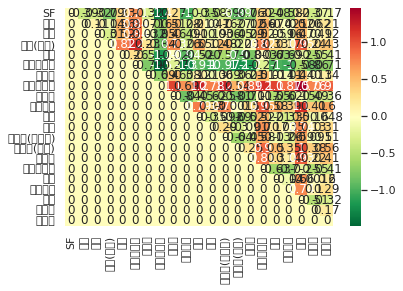

In [37]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

- 멜로로맨스와 애니메이션이 가장 편향성이 크게 나타난다.

## 루브릭
아래의 기준을 바탕으로 프로젝트를 평가합니다.

| 평가요소 | 상세기준 |
|----------|----------|
| 1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다. | 	워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다. |
| 2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다. | 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다. |
| 3. WEAT score 계산 및 시각화를 정상적으로 진행하였다. | 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다. |


## 회고
### 루브릭
1. 출력 결과를 보면, Word2Vec 모델이 영화, 사랑, 연극 등에 대해 의미상 관련된 단어들을 성공적으로 추출하였다.
2. TF-IDF 값이 높은 단어들 중에서 서로 다른 장르 간에 공유되지 않는 단어들을 선택하여 중복을 잘 제거하였습니다. 
3.heatmap으로 시각화를 진행하였다.

### 느낀점
- 수식 자체가 아직까지 이해가 되지 않는다.
- 데이터의 편향이 있을 수 있다는 것을 알고 있었는데 이것을 평가할 수 있는 지표를 배울 수 있어서 재미있었다. 이 편향들을 임베딩을 만드는 모델에서 처리해야할 것 같다.
- 예술 영화와 일반 영화에 대한 구분 기준이 명확하지 않다고 생각한다. 두 장르를 구분하는 대표 단어들을 보면 중복되는 부분이 많아 모호하다고 느꼇다.
- 오늘 배운 내용을 어디에 활용해 볼 수 있는지 고민해보아야겠다.